## Overview
Tasks: There are two parts/tasks in this tutorial: 
1. Developing a deep learning system for perception of signboards in PyTorch 
2. Rewriting our code using PyTorch Lightning

- Time: If you are comfortable with PyTorch, this tutorial should take around 1-2 hours max.


### Import required libraries and packages

In [63]:
# If you run on Jupyter Lab uncomment bellow comment
#! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"

# If you run on google colab uncomment bellow comment
# !pip install "pytorch-lightning" "torchmetrics"  -qq

# If you are running on your IDE (e.g VSCode) select the virtual environment that you have created as your python kernel
import os

import random

import matplotlib.colors as mpcol

import numpy as np # it's numpy, of course we need it!

import pandas as pd # for handling data

import matplotlib.pyplot as plt # for plotting

import math

from PIL import Image

import torch # this is PyTorch
import torch.nn as nn # The torch.nn module contains the building blocks for our neural networks
from torch.nn import functional as F # functional is a subpackage that contains various different deep learning functions (e.g activation functions)
from torch import optim # is a package that implements various optimization algorithms used for training
from torch.utils.data.dataset import Dataset # We require the Dataset and DataLoader classes if we are handling custom data
from torch.utils.data import DataLoader, random_split

import torchmetrics # will need to install this separately, contains implementations for various metrics (e.g Accuracy)
import torchvision # will need to install this separately, consists popular datasets, model architectures, and common image transformations for computer vision.

from torchmetrics import Accuracy
from torchvision import transforms
import torchvision.transforms.functional as fn

from pytorch_lightning import LightningModule, Trainer, seed_everything # PyTorch lightning is essentially an abstraction of vanilla PyTorch
                                                                        # This is an optional install/import, but from personal experience I find
                                                                        # coding neural networks with lightning much easier (we'll look at the details in the slides)

from pytorch_lightning.callbacks.progress import TQDMProgressBar # Progress bar that lets you know that something is actually happening
from pytorch_lightning.loggers import CSVLogger # Logging function to log information after every training epoch (e.g train accuracy)
from pytorch_lightning.callbacks import Callback, ModelCheckpoint # For saving and loading checkpoints. Callbacks allow you to call functions after every training epoch

from tqdm import tqdm

# For reproducability
seed_everything(1234, workers=True)

# Define GPU number
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu') 

Global seed set to 1234


In [20]:
print(device)
print(torch.cuda.is_available())

cuda:0
True


### Dataset Preparation

Before we begin, we need to prepare our dataset. We will be using the German Traffic Sign Recognition Benchmark (GTSRB) dataset, which can be found at this link: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign (642 MB)

The data will be downloaded as a zip file, which you can then extract. Make sure to place all folders/files into this directory (Tutorial_2).

This whole process could take a while, especially extracting and copying over the files, so give yourself some time before coding to get this data ready (it took me 30min!).

In [27]:
DATA_DIR = '../Tutorial_2/data'
# TEST_DIR = '../Tutorial_2/data/Test'
# TRAIN_DIR = '../Tutorial_2/data/Train'
NUM_CATEGORIES = 43

In [28]:
labels = ['20 km/h', '30 km/h', '50 km/h', '60 km/h', '70 km/h', '80 km/h', '80 km/h end', '100 km/h', '120 km/h', 'No overtaking',
               'No overtaking for trucks', 'Crossroad with secondary way', 'Main road', 'Give way', 'Stop', 'Road up', 'Road up for truck', 'Block',
               'Other dangerous', 'Turn left', 'Turn right', 'Winding road', 'Hollow road', 'Slippery road', 'Narrowing road', 'Roadwork', 'Traffic light',
               'Pedestrian', 'Children', 'Bike', 'Snow', 'Deer', 'End of the limits', 'Only right', 'Only left', 'Only straight', 'Only straight and right', 
               'Only straight and left', 'Take right', 'Take left', 'Circle crossroad', 'End of overtaking limit', 'End of overtaking limit for truck']

In [29]:
# This function just visualises some of the images
def visualise_data(images, categories=None, 
                   test_categories=None,
                   class_names = labels, 
                   images_per_row = 5):
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(3*images_per_row, 3*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        ax = plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        # ----
        ax.imshow(np.array(images[i]).astype('uint8'))
        if test_categories is not None:
          if int(test_categories[i]) == int(categories[i]):
            ax.set_title("Source: " + class_names[int(categories[i])] + "\nPredicted: " + class_names[int(test_categories[i])], fontsize=10, color='green')
          else:
            ax.set_title("Source: " + class_names[int(categories[i])] + "\nPredicted: " + class_names[int(test_categories[i])], fontsize=10, color='red')
        else:
          ax.set_title(class_names[int(categories[i])])
        # ----
    plt.show()

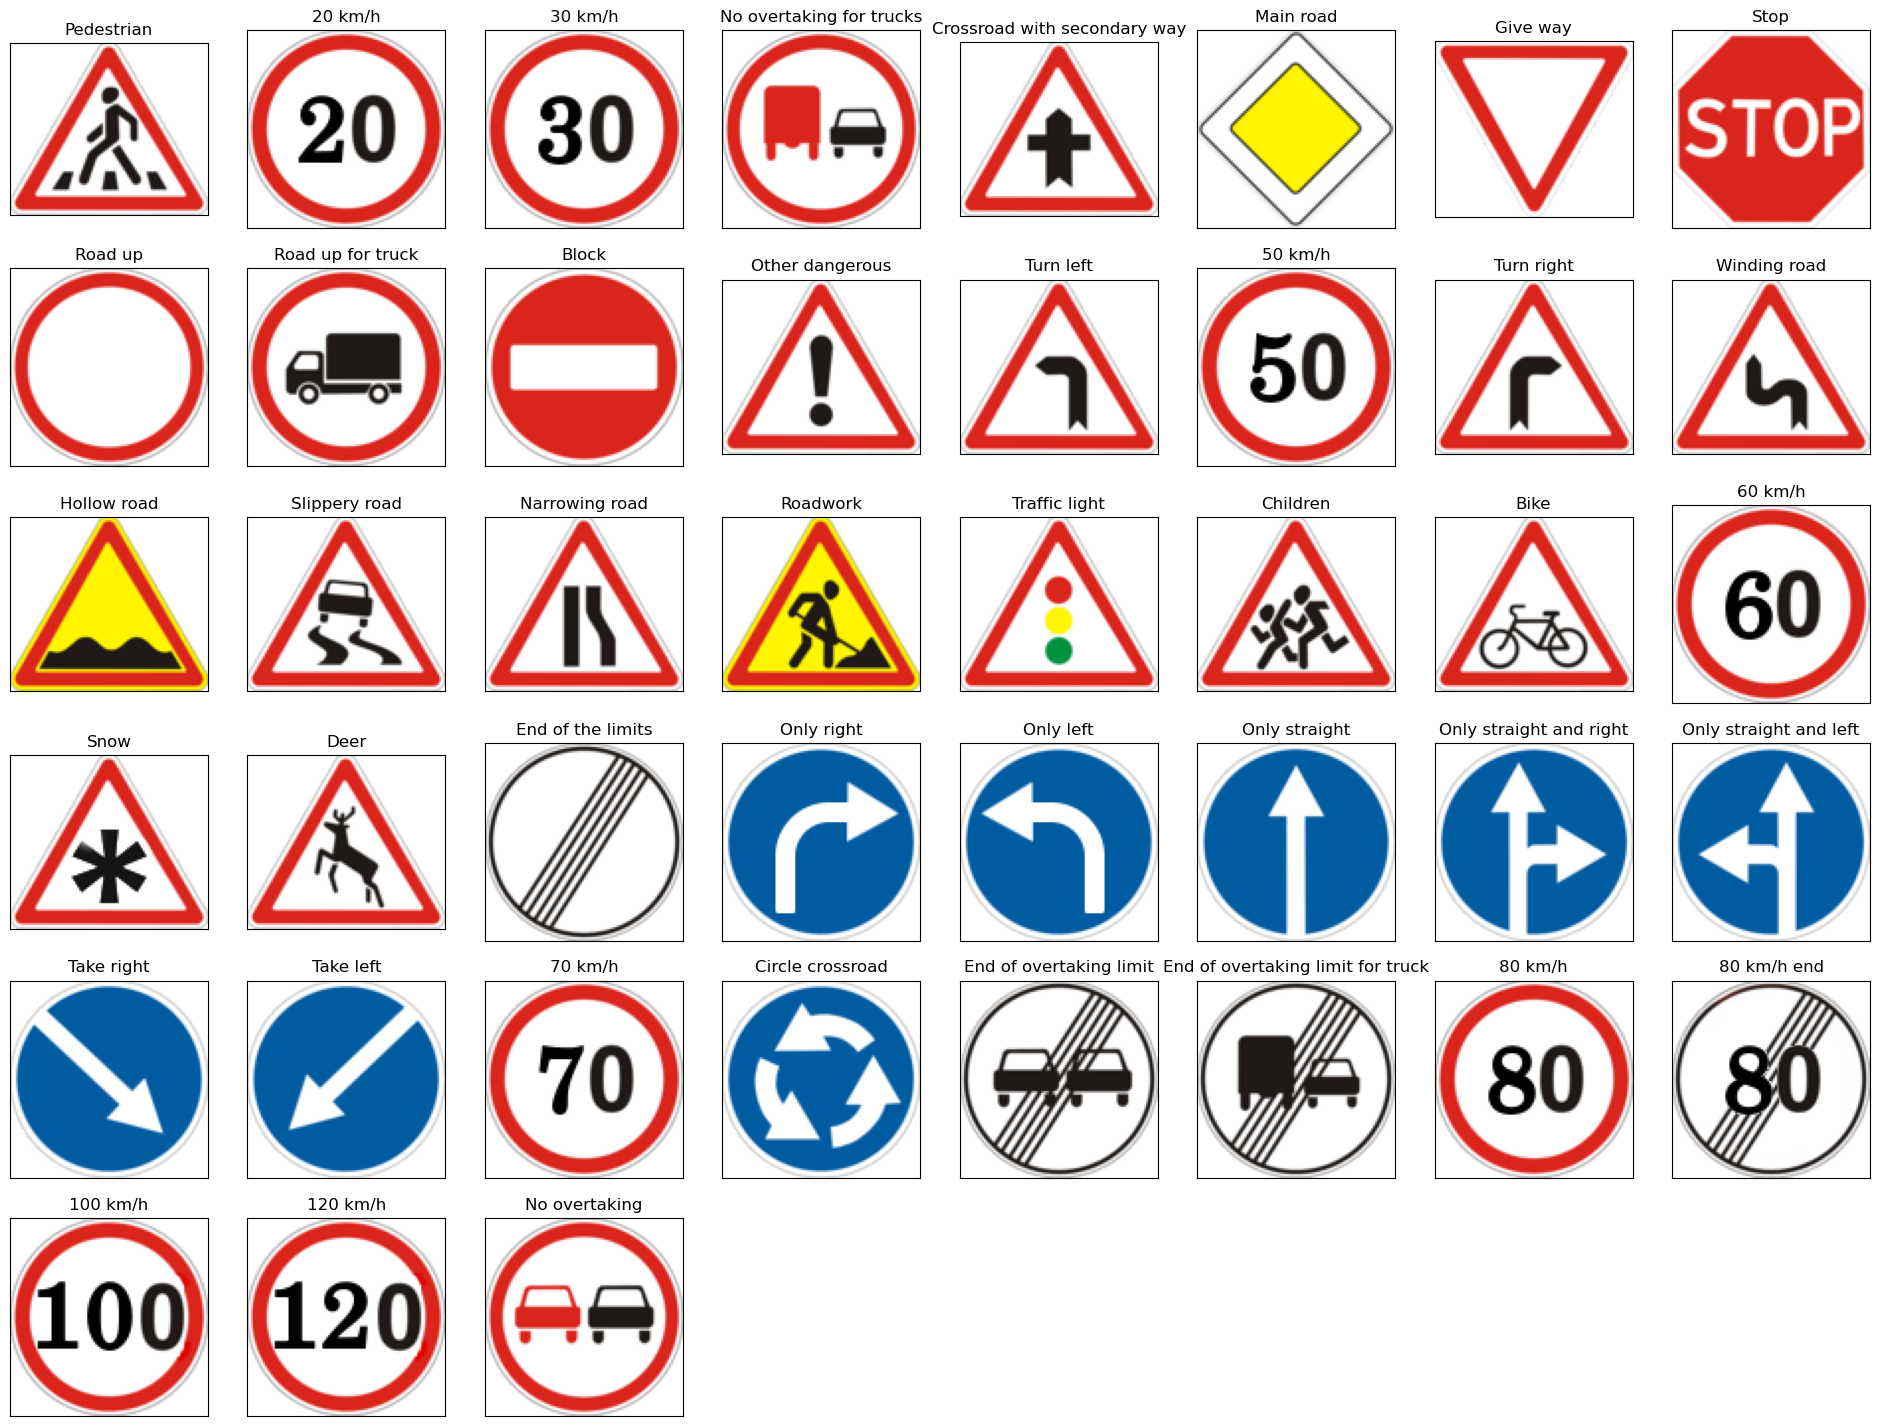

In [31]:
# Printing out the labels for all 43 classes
meta_csv = pd.read_csv(DATA_DIR + '/Meta.csv')
class_im_paths = meta_csv.loc[:,"Path"]
class_images = []
for image in class_im_paths:
  class_images.append(Image.open(DATA_DIR + "/" + image))

class_Id = meta_csv.loc[:,"ClassId"]

visualise_data(class_images, categories = class_Id, class_names=labels, images_per_row=8)

In [32]:
# To keep our model compact, we will utilise a 32x32x3 input by resizing our images to this size
# Don't worry, CNNs are pretty powerful and we should still be able to get a good result!
IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3

In [78]:
class TrafficSignData(Dataset):
    def __init__(self, train=True, transform=None):
        self.images = []
        self.labels = []

        if train:
            self.path = DATA_DIR + '/Train'
            self.directory = os.listdir(self.path) # list all subfolders

            for folder in self.directory:
                sub_path = self.path + "/" + str(folder)
                image_path = os.listdir(sub_path) # list images in each subfolder (each subfolder represents one of the 43 classes)
                for file in image_path:
                    if file[-1] == 'r': # NOTE THIS JANKY AS SOLUTION IS ONLY BECAUSE I HAVE "ZoneIdentifier" files for some reason when i copy over to WSL
                        continue
                    image = np.asarray(fn.resize((Image.open(sub_path + '/' + str(file))), (IMG_HEIGHT, IMG_WIDTH))).astype('float32')
                    self.images.append(image) # add image to our data array
                    self.labels.append(int(folder)) # add corresponding label to our label array
        else:
            test_csv = pd.read_csv(DATA_DIR + '/Test.csv')
            test_im_paths = test_csv.loc[:,"Path"]

            for image in test_im_paths:
                # self.images.append(np.asarray(Image.open(DATA_DIR + "/" + image)).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32'))
                self.images.append(np.asarray(fn.resize((Image.open(DATA_DIR + '/' + image)), (IMG_HEIGHT, IMG_WIDTH))).astype('float32'))

            self.labels = test_csv.loc[:, "ClassId"]

        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(idx): # idx will be a list of indexes as we will  be BATCHING
            idx = idx.tolist()

        sample = self.images[idx,:] # self.images is a two-dimensional array, the first dimension stores the image index and the second stores the image pixel values
        labels = self.labels[idx]
        if self.transform:  ## If there is a transform, apply it here to your sample
            sample = self.transform(sample)
        return sample, labels
    
    def __len__(self):
        return len(self.labels) # length of labels = length of images


In [79]:
BATCH_SIZE = 128     # the batch size for training task 1
N_WORKERS = 0        # don't worry too much about this

# Data augmentations - make sure to transform to tensor!
transform = transforms.Compose([transforms.ToTensor()])

# Create an instance of the FashionMNIST dataset for the training, validation and test set
# Remember we defined FashionMNIST(trn_val_tst = 0, transform=None), use ints 0-2 to define the train/val/test and make sure to pass in the transform
train_set = TrafficSignData(train=True, transform=transform)
test_set = TrafficSignData(train=False, transform=transform)

# Now we need to pass the dataset to the Pytorch dataloader class along with some other arguments
# DataLoader(dataset = dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS), make sure to shuffle the train dataset!
trainloader = DataLoader(dataset = train_set, shuffle=True, batch_size=BATCH_SIZE, num_workers=N_WORKERS)
testloader = DataLoader(dataset = test_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=N_WORKERS)

### Creating our Deep CNN Classifier

In [7]:
class CNN(nn.Module): # This is our main model
    def __init__(self, learning_rate=1e-4):
        super().__init__()

        self.learning_rate = learning_rate

        
        self.conv1 = ## YOUR CODE HERE ##

        self.conv2 = ## YOUR CODE HERE ##

        self.fc1 = ## YOUR CODE HERE ##

        self.out = ## YOUR CODE HERE ##

        # Define Max Pooling (Default stride = kernel size)
        self.maxpool = ## YOUR CODE HERE ##

    def forward(self, x):
        # conv 1
        x = ## YOUR CODE HERE ##

        # conv 2
        x = ## YOUR CODE HERE ##

        # flatten for linear layers
        x = x.view(x.shape[0],-1)

        # fc1
        x = ## YOUR CODE HERE ##

        # output
        out = ## YOUR CODE HERE ##
        # don't need softmax here since we'll use cross-entropy as our loss function
        return out

### Training our CNN Model

In [10]:
LEARNING_RATE = 1e-4

loss_function = nn.CrossEntropyLoss()

model = CNN(learning_rate=LEARNING_RATE)

optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [12]:
# simple empty array to log the loss
loss_log = []

# Perform 10 epochs
for epoch in range(2):
    loop = tqdm(trainloader)
    for idx, (x_batch, y_batch) in enumerate(loop):
        # perform forward pass
        target_pred = ## YOUR CODE HERE ##

        # calc loss
        loss = ## YOUR CODE HERE ##

        # zero gradients from previous step to avoid adding gradients
        ## YOUR CODE HERE ##

        # calculate new gradients
        ## YOUR CODE HERE ##

        # perform gradient descent
        ## YOUR CODE HERE ##

        loss_log.append(loss.item())

print("Loss:", loss.item())

100%|██████████| 469/469 [00:12<00:00, 38.97it/s]

Loss: 2.2995433807373047


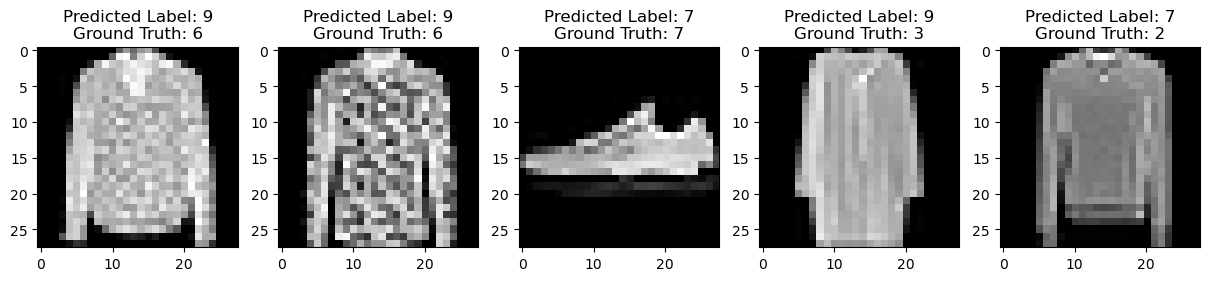

In [14]:
# Generate predictions using predict function
# Take a random test sample
test_data_iterator = iter(testloader)
data, labels = next(test_data_iterator)

predicted_labels = model(data).argmax(1)

data = data.reshape(BATCH_SIZE,28,28) # input data is not in 28x28 format -> for visualisation

input_im = data[0:5] # get first 5 images
ground_truth = labels[0:5] # get labels corresponding to first 5 images
predicted = predicted_labels[0:5] # get predictions corresponding to first 5 images

plt.figure(figsize=(15,8))
for i in range(5):
  plt.subplot(1,5,i+1)
  plt.imshow(input_im[i], cmap = "gray")
  plt.title(f'Predicted Label: {predicted[i]}\nGround Truth: {ground_truth[i]}')
